<font color="#483D8B">
<h1  align="center"> Recognizing Emotion in Speech With Neural Networks </h1>
<div align="center">
<font size=3><b>
<br>INET 4061 Project Final
<br>Tony Zeng
<br>December 9, 2019
<br></font></b></div>

# Overview
Human emotions can be found through our daily speech. If we are angry, someone might raise their voice. If someone is sad, you might hear abrupt speech patterns. This project will look into audio files from both a male and female to predict such emotions such as happy, sad, angry, etc. 
<br/>
<br/>

There are some major obstacles with speech emotion recognition:
* Emotions are subjective, people would interpret it differently. It is hard to define the notion of emotions.
* Annotating an audio recording is challenging. Should we label a single word, sentence or a whole conversation? How many emotions should we define to recognize?
* Collecting data is complex. There are lots of audio data can be achieved from films or news. However, both of them are biased since news reporting has to be neutral and actors’ emotions are imitated. It is hard to look for neutral audio recording without any bias.
* Labeling data require high human and time cost. Unlike drawing a bounding box on an image, it requires trained personnel to listen to the whole audio recording, analysis it and give an annotation. The annotation result has to be evaluated by multiple individuals due to its subjectivity.

Definitions:
* Mel Frequency Cepstral Coefficient (MFCC): The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. 

References:
* https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3
* http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
* https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer
* https://github.com/marcogdepinto/Emotion-Classification-Ravdess/blob/master/EmotionsRecognition.ipynb

# Data

The data we will be using for this is the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). The database contains 24 professional actors (12 female, 12 male) vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.
<br/>

#### File naming convention
Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Emotions
In this database, we will be looking at a couple of different emotions, this includes:
* Neutral (Not in song version of data)
* Calm
* Happy
* Sad
* Angry
* Fearful
* Disgust (Not in song version of data)
* Surprised (Not in song version of data)

#### Steps to reproduce the data for this notebook
We will be using the Audio-only files. In specific, we will be using the Song files which contains 1012 files: 44 trials per actor X 23 actors = 1012.
1. To get the data, go to : https://zenodo.org/record/1188976#.XcuWi1dKiUl
2. Go down and look for the file named: Audio_Song_Actors_01-24.zip. The size of the file is 225.5 MB.
3. Download the ZIP file to your computer
4. Create a folder named "ravdess" where your jupyter notebook is located.
5. Extract the contents in the ZIP folder, the copy over the directories with the following format: "Actor_XX", where "XX" is the actor number. If you look at the file path, it should look something like "C:\Users\Tony\Documents\INET-4061-Project\ravdess\Actor_01" if extracted properly.

In [1]:
#Imports
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers

In [2]:
import time

path = 'ravdess/'
feeling_list = []

start_time = time.time()

#look at each file name, in specific, the number where it identifies the gender of the actor and the labeled emotion.
#We then create a list that contains the gender and emotion.
for subdir, dirs, files in os.walk(path):
    for file in files:
        if file[6:-16] == '02' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_calm')
        elif file[6:-16] == '02' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_calm')
        elif file[6:-16] == '03' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_happy')
        elif file[6:-16] == '03' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_happy')
        elif file[6:-16] == '04' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_sad')
        elif file[6:-16] == '04' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_sad')
        elif file[6:-16] == '05' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_angry')
        elif file[6:-16] == '05' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_angry')
        elif file[6:-16] == '06' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_fearful')
        elif file[6:-16] == '06' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_fearful')
        elif file[:1] == 'a':
            feeling_list.append('male_angry')
        elif file[:1] == 'f':
            feeling_list.append('male_fearful')
        elif file[:1] == 'h':
            feeling_list.append('male_happy')
        elif file[:2] == 'sa':
            feeling_list.append('male_sad')

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.021004915237426758 seconds ---


# Exploratory Data Analysis

When listening to the sound files, there are two sentences used by the actors for the audio recording:
1. Kids are talking by the door.
2. Dogs are sitting by the door.

In [3]:
mylist = os.listdir('ravdess')
print(mylist)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
#Take a look at one of the audio files
data, sampling_rate = librosa.load(r'C:\Users\Tony\Documents\INET 4061\INET-4061-Project\ravdess\Actor_01\03-02-01-01-01-01-01.wav')

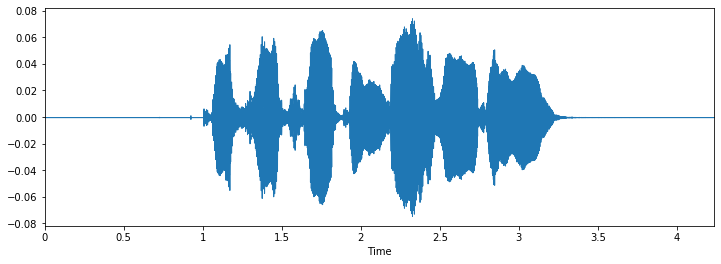

In [5]:
%matplotlib inline
import pandas as pd
import glob

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

This is the waveform graph for one of the audio files in our dataset. The audio file we used was labeled as 03-02-01-01-01-01-01.wav. This means that this file is audio-only, a song, neutral emotion, normal emotional intensity, statement: "Kids are talking by the door", 1st reptition, actor 1. This is what neutral emotion sound file should look like when looking at its waveform.

C:\Users\Tony\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Users\Tony\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


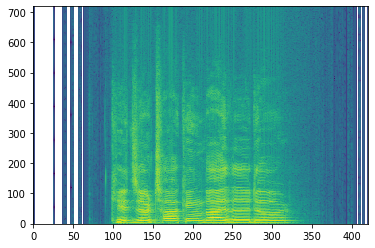

In [6]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys

sr,x = scipy.io.wavfile.read('ravdess/Actor_01/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

This is a spectogram. A spectogram shows the spectrum of frequencies of a signal as it varies with time.

In [7]:
#Verify that mfccs were populated in the list
print(feeling_list[1:10])

['male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_happy', 'male_happy']


In [8]:
labels = pd.DataFrame(feeling_list)

In [9]:
labels.head()

,0
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm


This part will extract features from the audio, in specific, we are using the MFCC as the feature.

To do so, we first load the audio file using librosa. We set the resampling type to be kaiser_fast. We only start loading the audio file after 2.5 seconds have passed and continue to do so for a total duration of 2.5 seconds.

In [10]:
df = pd.DataFrame(columns=['feature'])
bookmark=0

path = 'ravdess/'

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            if file[6:-16]!='01' and file[6:-16]!='07' and file[6:-16]!='08' and file[:2]!='su' and file[:1]!='n' and file[:1]!='d':
                X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                sample_rate = np.array(sample_rate)
                mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                    sr=sample_rate, 
                                                    n_mfcc=13), axis=0)
                feature = mfccs
                df.loc[bookmark] = [feature]
                bookmark=bookmark+1
        except ValueError:
            continue
            
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 29.26654362678528 seconds ---


In [11]:
df[:5]

,feature
0,"[-61.54295510658346, -61.67029675406895, -61.6..."
1,"[-60.61302926445464, -60.61302926445464, -60.6..."
2,"[-61.929473446188275, -61.929473446188275, -61..."
3,"[-59.151586921440064, -59.151586921440064, -59..."
4,"[-65.02310209265312, -65.02310209265312, -65.0..."


In [12]:
#Extract the feature values so that they are not in a single array
df3 = pd.DataFrame(df['feature'].values.tolist())

In [13]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-61.542955,-61.670297,-61.663520,-61.675594,-59.627474,-58.578270,-60.384651,-60.370816,-59.209070,-59.793678,...,-28.921122,-32.029650,-28.536739,-27.502652,-26.418862,-27.831207,-28.752036,-28.786452,-21.615861,-17.308698
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-26.426585,-24.405366,-23.668778,-26.999538,-31.112376,-29.247233,-25.843218,-25.077201,-26.445542,-23.854167
2,-61.929473,-61.929473,-61.929473,-61.929473,-60.674368,-60.394733,-61.859244,-61.559094,-61.015480,-59.214944,...,-26.654115,-29.230816,-31.035511,-30.716605,-32.136162,-31.681685,-30.169341,-28.785440,-21.420411,-17.509744
3,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.149453,-58.931153,...,-31.761590,-32.370957,-31.170328,-28.492162,-26.996384,-26.160202,-26.592119,-27.137036,-21.495017,-16.727303
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-26.300118,-25.822013,-26.811410,-28.635298,-30.002088,-32.346751,-34.095304,-34.079765,-23.301119,-17.947985


In [14]:
newdf = pd.concat([df3, labels], axis=1)

In [15]:
newdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542955,-61.670297,-61.663520,-61.675594,-59.627474,-58.578270,-60.384651,-60.370816,-59.209070,-59.793678,...,-32.029650,-28.536739,-27.502652,-26.418862,-27.831207,-28.752036,-28.786452,-21.615861,-17.308698,male_calm
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-24.405366,-23.668778,-26.999538,-31.112376,-29.247233,-25.843218,-25.077201,-26.445542,-23.854167,male_calm
2,-61.929473,-61.929473,-61.929473,-61.929473,-60.674368,-60.394733,-61.859244,-61.559094,-61.015480,-59.214944,...,-29.230816,-31.035511,-30.716605,-32.136162,-31.681685,-30.169341,-28.785440,-21.420411,-17.509744,male_calm
3,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.149453,-58.931153,...,-32.370957,-31.170328,-28.492162,-26.996384,-26.160202,-26.592119,-27.137036,-21.495017,-16.727303,male_calm
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-25.822013,-26.811410,-28.635298,-30.002088,-32.346751,-34.095304,-34.079765,-23.301119,-17.947985,male_calm


In [16]:
rnewdf = newdf.rename(index=str, columns={"0":"label"})
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542955,-61.670297,-61.663520,-61.675594,-59.627474,-58.578270,-60.384651,-60.370816,-59.209070,-59.793678,...,-32.029650,-28.536739,-27.502652,-26.418862,-27.831207,-28.752036,-28.786452,-21.615861,-17.308698,male_calm
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-24.405366,-23.668778,-26.999538,-31.112376,-29.247233,-25.843218,-25.077201,-26.445542,-23.854167,male_calm
2,-61.929473,-61.929473,-61.929473,-61.929473,-60.674368,-60.394733,-61.859244,-61.559094,-61.015480,-59.214944,...,-29.230816,-31.035511,-30.716605,-32.136162,-31.681685,-30.169341,-28.785440,-21.420411,-17.509744,male_calm
3,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.149453,-58.931153,...,-32.370957,-31.170328,-28.492162,-26.996384,-26.160202,-26.592119,-27.137036,-21.495017,-16.727303,male_calm
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-25.822013,-26.811410,-28.635298,-30.002088,-32.346751,-34.095304,-34.079765,-23.301119,-17.947985,male_calm


The shuffle function shuffles the dataframe in a consistent manner so that we are not going in order or emotions and actors/actresses. Without the shuffle, we would be going through numerical order of each actor's sound files which would not be a very representative test. So instead, we will shuffle the data to be more random.

In [17]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
462,-50.286129,-49.724326,-49.976722,-50.427459,-50.694890,-48.572475,-48.053596,-48.341270,-48.119297,-47.071027,...,-42.149279,-43.022464,-43.518211,-43.952423,-44.830362,-43.096116,-43.148461,-26.333191,-18.607353,female_sad
70,-48.022372,-48.022372,-48.022372,-48.022372,-48.022372,-48.022372,-48.022372,-48.022372,-48.022372,-48.022372,...,-37.584031,-37.825651,-33.713407,-30.086783,-32.358293,-34.128992,-31.971733,-27.191674,-21.460302,female_angry
640,-47.962406,-48.281716,-49.615417,-47.826264,-47.793799,-49.442234,-48.524412,-47.475045,-46.555715,-48.222409,...,-26.634506,-25.642192,-25.237556,-25.236957,-24.704709,-25.800303,-25.730495,-22.517693,-17.953088,male_calm
525,-67.863659,-67.863659,-67.863659,-67.863659,-67.863659,-67.863659,-67.863659,-67.863659,-67.863659,-67.863659,...,-44.051149,-43.487797,-41.909901,-43.718892,-46.512996,-45.603961,-43.038511,-30.276232,-22.617119,female_calm
215,-47.647759,-46.622142,-47.108506,-49.672266,-49.012337,-47.569330,-50.093369,-48.178015,-47.952236,-48.381695,...,-46.218039,-45.786740,-47.132282,-47.077281,-46.852689,-44.209291,-43.528670,-37.750349,-29.891962,female_happy
79,-51.095268,-51.123942,-51.005869,-50.640776,-50.974002,-50.861774,-50.656772,-50.600279,-50.586440,-50.662499,...,-30.613866,-35.520363,-38.142500,-39.404622,-38.475622,-39.854078,-42.392487,-25.993322,-18.706461,female_fearful
420,-51.406588,-52.277152,-51.893401,-52.951385,-51.787522,-51.462478,-51.924335,-51.368819,-53.146819,-52.760147,...,-28.981305,-29.003418,-29.918957,-28.580639,-27.936108,-27.211522,-25.882322,-19.936806,-15.842407,male_sad
544,-56.519842,-56.519842,-56.519842,-56.519842,-56.519842,-56.519842,-56.519842,-56.519842,-56.519842,-56.519842,...,-36.410506,-39.341640,-41.234619,-40.286299,-40.390539,-39.719417,-40.663287,-26.104663,-18.345803,female_angry
797,-50.464427,-49.193645,-48.768433,-47.979028,-48.638646,-49.577528,-50.470527,-49.114567,-49.443671,-49.009153,...,-17.999911,-21.148484,-22.674827,-23.044291,-22.530117,-22.725092,-23.003676,-14.397030,-7.610171,male_fearful
87,-53.963494,-54.192106,-54.703943,-54.632553,-54.572337,-54.658802,-54.673846,-54.176845,-54.206373,-54.094404,...,-24.965300,-23.345233,-23.784062,-23.679397,-23.181244,-24.142528,-26.261996,-25.352166,-23.324908,male_calm


In [18]:
#Check for nulls
rnewdf.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
212    0
213    0
214    0
215    0
0      0
Length: 217, dtype: int64

In [19]:
#If null exists, set it to 0
rnewdf = rnewdf.fillna(0)

### Divide the data into test and train

The way we divide the test and train data is by creating an array with the shape of the length of rnewdf where the values are less than 0.8. Our train data will be whatever is equal to true in newdf1 while our test is the complement of newdf1, which is whatever was equal to false 
in newdf1.

In [20]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8

In [21]:
newdf1[1:10]

array([ True,  True,  True,  True, False,  True,  True,  True,  True])

In [22]:
~newdf1[1:10]

array([False, False, False, False,  True, False, False, False, False])

In [23]:
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [24]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
317,-46.041807,-46.503038,-45.537581,-45.848066,-47.780096,-48.255046,-48.379031,-48.419750,-47.138094,-46.469352,...,-41.250428,-39.629344,-38.538455,-39.962862,-43.526083,-42.667347,-42.037138,-24.540109,-16.888001,female_fearful
487,-62.443739,-59.021425,-58.321782,-57.676274,-56.835729,-55.323860,-54.222653,-53.469652,-51.546133,-50.254087,...,-33.179685,-33.402671,-33.158895,-33.661136,-33.249630,-31.225670,-31.087794,-29.026924,-26.075194,male_calm
553,-58.558904,-58.558904,-58.558904,-58.558904,-58.558904,-58.558904,-58.558904,-58.558904,-58.558904,-58.572793,...,-43.229748,-42.570451,-40.935713,-41.605625,-40.207375,-41.417679,-43.322340,-35.140060,-27.795936,female_fearful
393,-47.559454,-46.952800,-46.029665,-45.643964,-45.393950,-46.039500,-46.395240,-47.277190,-45.923697,-44.394762,...,-38.472220,-37.000428,-36.662633,-37.369145,-38.407979,-35.355184,-34.987680,-19.146210,-13.405656,female_fearful
760,-49.942101,-49.266232,-51.123735,-50.176504,-51.357939,-52.636095,-53.170590,-51.718994,-52.678844,-52.712501,...,-24.124298,-24.004257,-23.819330,-22.000117,-22.862384,-26.212874,-29.178729,-21.356600,-16.982446,male_calm
501,-43.326909,-45.433260,-50.868973,-51.341787,-52.021680,-50.278924,-49.387444,-52.529340,-53.844576,-54.707393,...,-35.842986,-34.170010,-34.082694,-33.097667,-33.813998,-35.057822,-35.314025,-30.363638,-24.053005,male_sad
569,-49.819811,-49.599923,-49.554654,-50.902161,-51.475208,-51.207952,-51.885335,-51.587788,-50.639295,-50.558442,...,-24.787331,-24.871293,-24.350132,-25.034222,-27.087750,-26.915955,-26.827097,-20.276347,-14.929862,male_happy
239,-37.660388,-37.086312,-37.610335,-37.602700,-36.305917,-35.454825,-37.015729,-38.974077,-39.591095,-38.093264,...,-39.497437,-36.987894,-37.952055,-38.630132,-38.291428,-39.162170,-38.627410,-27.539998,-21.681502,female_fearful
52,-54.562832,-54.639356,-54.432250,-54.225971,-54.435771,-54.974290,-54.965230,-54.375518,-54.036374,-53.341752,...,-45.334320,-44.607711,-43.144793,-43.631858,-43.960882,-43.849876,-43.026436,-22.896559,-14.296965,female_happy
201,-61.479051,-62.185810,-62.569354,-60.230214,-60.888022,-61.378749,-61.197489,-59.228819,-60.406585,-63.710003,...,-42.650351,-43.551402,-43.118959,-44.679946,-45.247894,-44.543859,-46.664218,-44.910792,-37.738036,female_calm


In [25]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [26]:
from tensorflow.python.keras import utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

print(y_train[:5])
#Use label encoder as our current y_train/y_test is in text, so need to convert into numerical data through LabelEncoder.
lb = LabelEncoder()

y_train = utils.to_categorical(lb.fit_transform(y_train))
y_test = utils.to_categorical(lb.fit_transform(y_test))

[['female_sad']
 ['female_angry']
 ['male_calm']
 ['female_calm']
 ['female_happy']]


C:\Users\Tony\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
X_train.shape

(730, 216)

# Model

### Building our neural network
We will be building our neural network in this part.
<br/>
<br/>
Reference:
* https://github.com/marcogdepinto/Emotion-Classification-Ravdess/blob/master/EmotionsRecognition.ipynb

In [29]:
#We need to expand the dimensions of the array, so we use expand_dims to add a 3rd dimension to it.
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [30]:
x_traincnn.shape, x_testcnn.shape

((730, 216, 1), (190, 216, 1))

In [31]:
#5 Layer CNN Architecture: 4 Conv1D layers and 1 Dense layer
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1))) #Layer 1
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same')) #Layer 2
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',)) #Layer 3
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',)) #Layer 4
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10)) #Layer 5
model.add(Activation('softmax'))
opt = tf.optimizers.RMSprop(lr=0.00001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
#Commented out so it won't run again, uncomment if want to retrain
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Train on 730 samples, validate on 190 samples
Epoch 1/700
730/730 [==============================] - 2s 3ms/sample - loss: 2.5080 - accuracy: 0.1466 - val_loss: 2.2250 - val_accuracy: 0.1789
Epoch 2/700
730/730 [==============================] - 1s 2ms/sample - loss: 2.2170 - accuracy: 0.1986 - val_loss: 2.1832 - val_accuracy: 0.2263
Epoch 3/700
730/730 [==============================] - 2s 2ms/sample - loss: 2.1738 - accuracy: 0.2041 - val_loss: 2.1402 - val_accuracy: 0.1947
Epoch 4/700
730/730 [==============================] - 2s 2ms/sample - loss: 2.1385 - accuracy: 0.2301 - val_loss: 2.1196 - val_accuracy: 0.1737
Epoch 5/700
730/730 [==============================] - 1s 2ms/sample - loss: 2.1084 - accuracy: 0.2452 - val_loss: 2.1146 - val_accuracy: 0.2316
Epoch 6/700
730/730 [==============================] - 2s 2ms/sample - loss: 2.0750 - accuracy: 0.2356 - val_loss: 2.0797 - val_accuracy: 0.2421
Epoch 7/700
730/730 [==============================] - 2s 2ms/sample - loss: 2.0470 

Epoch 57/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3555 - accuracy: 0.4658 - val_loss: 1.4489 - val_accuracy: 0.4158
Epoch 58/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3453 - accuracy: 0.4767 - val_loss: 1.4284 - val_accuracy: 0.3895
Epoch 59/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3377 - accuracy: 0.4753 - val_loss: 1.4472 - val_accuracy: 0.3842
Epoch 60/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3271 - accuracy: 0.4781 - val_loss: 1.4310 - val_accuracy: 0.3842
Epoch 61/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3230 - accuracy: 0.4822 - val_loss: 1.4268 - val_accuracy: 0.4105
Epoch 62/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3107 - accuracy: 0.4959 - val_loss: 1.5137 - val_accuracy: 0.3368
Epoch 63/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.3206 - accuracy: 0.4767 - val_loss: 1.3948 -

730/730 [==============================] - 2s 2ms/sample - loss: 1.0965 - accuracy: 0.5836 - val_loss: 1.2667 - val_accuracy: 0.4158
Epoch 114/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.1021 - accuracy: 0.5849 - val_loss: 1.2587 - val_accuracy: 0.4421
Epoch 115/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.0882 - accuracy: 0.5890 - val_loss: 1.3515 - val_accuracy: 0.4211
Epoch 116/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.0872 - accuracy: 0.5808 - val_loss: 1.3087 - val_accuracy: 0.3579
Epoch 117/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.0963 - accuracy: 0.5863 - val_loss: 1.2720 - val_accuracy: 0.4368
Epoch 118/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.0831 - accuracy: 0.5822 - val_loss: 1.3724 - val_accuracy: 0.4053
Epoch 119/700
730/730 [==============================] - 2s 2ms/sample - loss: 1.0840 - accuracy: 0.5603 - val_loss: 1.2533 - val_ac

Epoch 169/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.9930 - accuracy: 0.6164 - val_loss: 1.2063 - val_accuracy: 0.4263
Epoch 170/700
730/730 [==============================] - 1s 2ms/sample - loss: 0.9809 - accuracy: 0.6205 - val_loss: 1.2143 - val_accuracy: 0.4579
Epoch 171/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.9845 - accuracy: 0.6055 - val_loss: 1.2469 - val_accuracy: 0.4526
Epoch 172/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.9735 - accuracy: 0.6110 - val_loss: 1.1949 - val_accuracy: 0.4474
Epoch 173/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.9711 - accuracy: 0.6178 - val_loss: 1.2790 - val_accuracy: 0.4211
Epoch 174/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.9802 - accuracy: 0.6247 - val_loss: 1.1860 - val_accuracy: 0.4526
Epoch 175/700
730/730 [==============================] - 1s 2ms/sample - loss: 0.9748 - accuracy: 0.6151 - val_loss: 1

Epoch 225/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8971 - accuracy: 0.6644 - val_loss: 1.2074 - val_accuracy: 0.4684
Epoch 226/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8961 - accuracy: 0.6589 - val_loss: 1.2289 - val_accuracy: 0.3947
Epoch 227/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8889 - accuracy: 0.6712 - val_loss: 1.2324 - val_accuracy: 0.4632
Epoch 228/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8814 - accuracy: 0.6630 - val_loss: 1.1968 - val_accuracy: 0.4895
Epoch 229/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8826 - accuracy: 0.6630 - val_loss: 1.2017 - val_accuracy: 0.4579
Epoch 230/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8769 - accuracy: 0.6616 - val_loss: 1.1893 - val_accuracy: 0.4842
Epoch 231/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8836 - accuracy: 0.6671 - val_loss: 1

Epoch 281/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8178 - accuracy: 0.6836 - val_loss: 1.1928 - val_accuracy: 0.4632
Epoch 282/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8176 - accuracy: 0.6822 - val_loss: 1.1641 - val_accuracy: 0.5053
Epoch 283/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8095 - accuracy: 0.6822 - val_loss: 1.2016 - val_accuracy: 0.4895
Epoch 284/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8118 - accuracy: 0.6945 - val_loss: 1.1730 - val_accuracy: 0.4842
Epoch 285/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8103 - accuracy: 0.6932 - val_loss: 1.1220 - val_accuracy: 0.5368
Epoch 286/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8120 - accuracy: 0.6836 - val_loss: 1.1260 - val_accuracy: 0.5421
Epoch 287/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.8103 - accuracy: 0.6945 - val_loss: 1

Epoch 337/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7438 - accuracy: 0.7192 - val_loss: 1.1133 - val_accuracy: 0.5105
Epoch 338/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7439 - accuracy: 0.7151 - val_loss: 1.1547 - val_accuracy: 0.4842
Epoch 339/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7444 - accuracy: 0.7096 - val_loss: 1.1394 - val_accuracy: 0.5000
Epoch 340/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7401 - accuracy: 0.7123 - val_loss: 1.2050 - val_accuracy: 0.4737
Epoch 341/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7305 - accuracy: 0.7178 - val_loss: 1.1145 - val_accuracy: 0.5211
Epoch 342/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7337 - accuracy: 0.7370 - val_loss: 1.1269 - val_accuracy: 0.5211
Epoch 343/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.7230 - accuracy: 0.7425 - val_loss: 1

Epoch 393/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6746 - accuracy: 0.7507 - val_loss: 1.1093 - val_accuracy: 0.5263
Epoch 394/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6519 - accuracy: 0.7534 - val_loss: 1.1535 - val_accuracy: 0.5263
Epoch 395/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6618 - accuracy: 0.7575 - val_loss: 1.1496 - val_accuracy: 0.4947
Epoch 396/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6686 - accuracy: 0.7671 - val_loss: 1.1176 - val_accuracy: 0.5474
Epoch 397/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6633 - accuracy: 0.7521 - val_loss: 1.1111 - val_accuracy: 0.5211
Epoch 398/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6644 - accuracy: 0.7575 - val_loss: 1.2636 - val_accuracy: 0.4737
Epoch 399/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6620 - accuracy: 0.7507 - val_loss: 1

Epoch 449/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5830 - accuracy: 0.7932 - val_loss: 1.1654 - val_accuracy: 0.5316
Epoch 450/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.6003 - accuracy: 0.7767 - val_loss: 1.1831 - val_accuracy: 0.4947
Epoch 451/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5896 - accuracy: 0.7959 - val_loss: 1.1405 - val_accuracy: 0.5316
Epoch 452/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5998 - accuracy: 0.7863 - val_loss: 1.1171 - val_accuracy: 0.5211
Epoch 453/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5986 - accuracy: 0.7767 - val_loss: 1.1397 - val_accuracy: 0.5158
Epoch 454/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5884 - accuracy: 0.7658 - val_loss: 1.1872 - val_accuracy: 0.4947
Epoch 455/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5908 - accuracy: 0.7877 - val_loss: 1

Epoch 505/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5327 - accuracy: 0.8164 - val_loss: 1.1165 - val_accuracy: 0.5316
Epoch 506/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5174 - accuracy: 0.8096 - val_loss: 1.1153 - val_accuracy: 0.5053
Epoch 507/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5425 - accuracy: 0.7959 - val_loss: 1.1547 - val_accuracy: 0.5000
Epoch 508/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5255 - accuracy: 0.8110 - val_loss: 1.2217 - val_accuracy: 0.4737
Epoch 509/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5181 - accuracy: 0.8219 - val_loss: 1.1439 - val_accuracy: 0.5158
Epoch 510/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5161 - accuracy: 0.8356 - val_loss: 1.2253 - val_accuracy: 0.4842
Epoch 511/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.5241 - accuracy: 0.8082 - val_loss: 1

Epoch 561/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4487 - accuracy: 0.8616 - val_loss: 1.2131 - val_accuracy: 0.5211
Epoch 562/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4513 - accuracy: 0.8493 - val_loss: 1.1143 - val_accuracy: 0.5632
Epoch 563/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4437 - accuracy: 0.8575 - val_loss: 1.2350 - val_accuracy: 0.5105
Epoch 564/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4520 - accuracy: 0.8438 - val_loss: 1.1802 - val_accuracy: 0.5526
Epoch 565/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4535 - accuracy: 0.8397 - val_loss: 1.1553 - val_accuracy: 0.5526
Epoch 566/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4593 - accuracy: 0.8493 - val_loss: 1.1444 - val_accuracy: 0.5105
Epoch 567/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.4516 - accuracy: 0.8616 - val_loss: 1

Epoch 617/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3937 - accuracy: 0.8836 - val_loss: 1.2078 - val_accuracy: 0.5316
Epoch 618/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3876 - accuracy: 0.8836 - val_loss: 1.1838 - val_accuracy: 0.5105
Epoch 619/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3813 - accuracy: 0.8932 - val_loss: 1.1794 - val_accuracy: 0.5474
Epoch 620/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3881 - accuracy: 0.8932 - val_loss: 1.2002 - val_accuracy: 0.5632
Epoch 621/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3825 - accuracy: 0.8877 - val_loss: 1.1568 - val_accuracy: 0.5368
Epoch 622/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3943 - accuracy: 0.8767 - val_loss: 1.2028 - val_accuracy: 0.5105
Epoch 623/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3766 - accuracy: 0.8849 - val_loss: 1

Epoch 673/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3354 - accuracy: 0.9014 - val_loss: 1.2412 - val_accuracy: 0.5368
Epoch 674/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3210 - accuracy: 0.9192 - val_loss: 1.1626 - val_accuracy: 0.5526
Epoch 675/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3149 - accuracy: 0.9192 - val_loss: 1.1952 - val_accuracy: 0.5211
Epoch 676/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3214 - accuracy: 0.9151 - val_loss: 1.1969 - val_accuracy: 0.5263
Epoch 677/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3213 - accuracy: 0.9247 - val_loss: 1.2529 - val_accuracy: 0.5316
Epoch 678/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3179 - accuracy: 0.9096 - val_loss: 1.1803 - val_accuracy: 0.5526
Epoch 679/700
730/730 [==============================] - 2s 2ms/sample - loss: 0.3143 - accuracy: 0.9041 - val_loss: 1

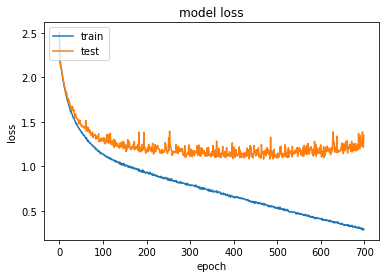

In [35]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

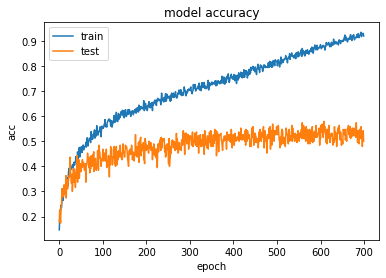

In [36]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save the Model

In [37]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Tony\Documents\INET 4061\INET-4061-Project\saved_models\Emotion_Voice_Detection_Model.h5 


### Reload the Saved Model

In [38]:
loaded_model = keras.models.load_model(r'C:\Users\Tony\Documents\INET 4061\INET-4061-Project\saved_models\Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

### Predicting Emotions on Test Data

In [39]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=16, 
                         verbose=1)

190/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [40]:
preds

array([[4.9029940e-01, 5.8008143e-04, 4.5134825e-01, ..., 1.5518668e-06,
        3.9000979e-06, 3.9900231e-05],
       [7.2507715e-01, 2.8327748e-11, 3.5837945e-02, ..., 9.6475054e-04,
        1.4682895e-05, 8.3492189e-08],
       [8.4034906e-07, 3.2699077e-10, 2.9218061e-09, ..., 1.8657070e-03,
        1.2372269e-03, 4.5767531e-05],
       ...,
       [8.0140352e-02, 1.4776032e-02, 8.7087864e-01, ..., 7.8997264e-06,
        1.5152655e-06, 8.8487133e-05],
       [4.3903757e-04, 6.5839939e-02, 8.8941537e-02, ..., 2.9334420e-04,
        4.8252650e-06, 5.2245436e-03],
       [6.8791932e-01, 1.7779578e-03, 5.2872393e-02, ..., 1.5932518e-04,
        6.7796657e-04, 1.5735093e-01]], dtype=float32)

In [41]:
#Return the indices of the max element, which will be our predictions
preds1=preds.argmax(axis=1)

In [42]:
preds1

array([0, 0, 5, 7, 6, 4, 6, 0, 9, 4, 7, 0, 5, 2, 2, 2, 0, 0, 3, 1, 6, 2,
       6, 0, 8, 2, 5, 5, 7, 5, 2, 9, 6, 0, 7, 5, 2, 5, 6, 3, 2, 2, 9, 4,
       7, 5, 9, 7, 9, 4, 8, 7, 7, 7, 7, 7, 8, 1, 9, 1, 4, 4, 9, 5, 7, 9,
       8, 9, 2, 6, 4, 5, 2, 8, 2, 3, 1, 8, 3, 3, 4, 9, 7, 3, 0, 6, 2, 7,
       3, 9, 2, 4, 7, 5, 2, 3, 8, 5, 5, 1, 2, 0, 2, 4, 7, 5, 2, 2, 3, 2,
       6, 8, 4, 2, 2, 7, 2, 6, 5, 2, 9, 5, 2, 8, 5, 9, 5, 8, 7, 5, 5, 5,
       5, 2, 2, 2, 0, 3, 6, 5, 9, 1, 1, 7, 5, 6, 4, 2, 8, 2, 5, 9, 5, 8,
       0, 1, 5, 6, 3, 4, 2, 2, 0, 9, 4, 7, 5, 2, 8, 7, 2, 5, 1, 8, 5, 3,
       9, 2, 0, 1, 0, 0, 7, 6, 7, 4, 1, 2, 4, 0], dtype=int64)

In [43]:
#Return a copy of preds1 collapsed into one dimension
abc = preds1.astype(int).flatten()

In [44]:
predictions = (lb.inverse_transform((abc)))

In [45]:
preddf = pd.DataFrame({'Predicted Values': predictions})
preddf[:10]

,Predicted Values
0,female_angry
1,female_angry
2,male_angry
3,male_fearful
4,male_calm
5,female_sad
6,male_calm
7,female_angry
8,male_sad
9,female_sad


In [46]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [47]:
actualdf = pd.DataFrame({'Actual Values': actualvalues})
actualdf[:10]

,Actual Values
0,female_fearful
1,female_angry
2,male_angry
3,male_sad
4,male_sad
5,female_sad
6,male_calm
7,female_angry
8,male_calm
9,female_calm


In [48]:
finaldf = actualdf.join(preddf)

In [49]:
finaldf[10:20]

,Actual Values,Predicted Values
10,male_angry,male_fearful
11,female_happy,female_angry
12,male_angry,male_angry
13,female_happy,female_fearful
14,female_fearful,female_fearful
15,female_fearful,female_fearful
16,female_happy,female_angry
17,female_angry,female_angry
18,female_sad,female_happy
19,female_calm,female_calm


In [50]:
finaldf.groupby('Actual Values').count()

,Predicted Values
Actual Values,
female_angry,13
female_calm,21
female_fearful,19
female_happy,17
female_sad,21
male_angry,24
male_calm,15
male_fearful,15
male_happy,22


In [51]:
finaldf.groupby('Predicted Values').count()

,Actual Values
Predicted Values,
female_angry,17
female_calm,11
female_fearful,36
female_happy,12
female_sad,16
male_angry,30
male_calm,14
male_fearful,23
male_happy,14


### Checking Accuracy of the Loaded Model

In [52]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

190/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Conclusion

After experiementing with my CNN architecture and optimizations, I was finally able to stop my model from overfitting. Initially, after around 300 to 400 epochs, my model's loss kept increasing higher and higher. It seemed that my model was overfitting so I tried a couple of different optimizations to minimize loss. Using this model, I was able to achieve 50% accuracy on predicting emotions from the audio files.

Things I have learned from this project:
* I have learned what are important features for audio files (MFCCs)
* Learned more about using TensorFlow and creating neural networks
* Learn how to process audio files to predict classification

Things I would like to try different for future work:
* Achieve a higher accuracy. I want to look into the possibility of splitting my data different as this might have had a huge impact on why my loss was increasing after the the first 300 epochs with different optimizers. 
* Try a different CNN architecture than the one I am using.
* Instead of using 2.5 seconds of audio, maybe I can look into using a longer duration of the file instead of what I am using now.
* Use the other dataset with 3 more emotions, which means 3 more classes I need to catch.